# Emotion Classifier


## Setup and Training of Model

In [1]:
# Imports

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import cv2

from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
pyplot.style.use(['dark_background'])

In [2]:
df = pd.read_csv("fer2013/fer2013.csv")
df.shape

(35887, 3)

In [3]:
# Emotion labels
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [4]:
label_to_text = {0: "anger",
                    1: "disgust",
                    2: "fear",
                    3: "happiness",
                    4: "sadness",
                    5: "surprise",
                    6: "neutral"}

In [5]:
# Convert string inputs of pixels to 48x48 grid for images
first_img = df.pixels.loc[0]
first_grid = np.array(first_img.split(" ")).reshape(48, 48)
first_grid

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ...,
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], dtype='<U3')

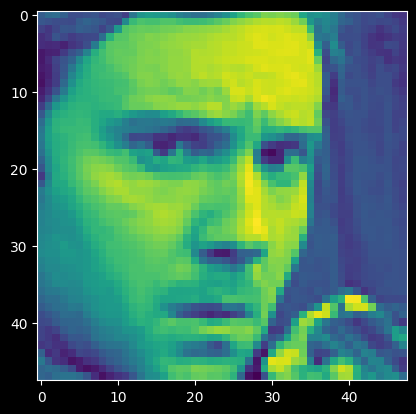

In [6]:
# Display image using pyplot
pyplot.imshow(first_grid.astype('float'))

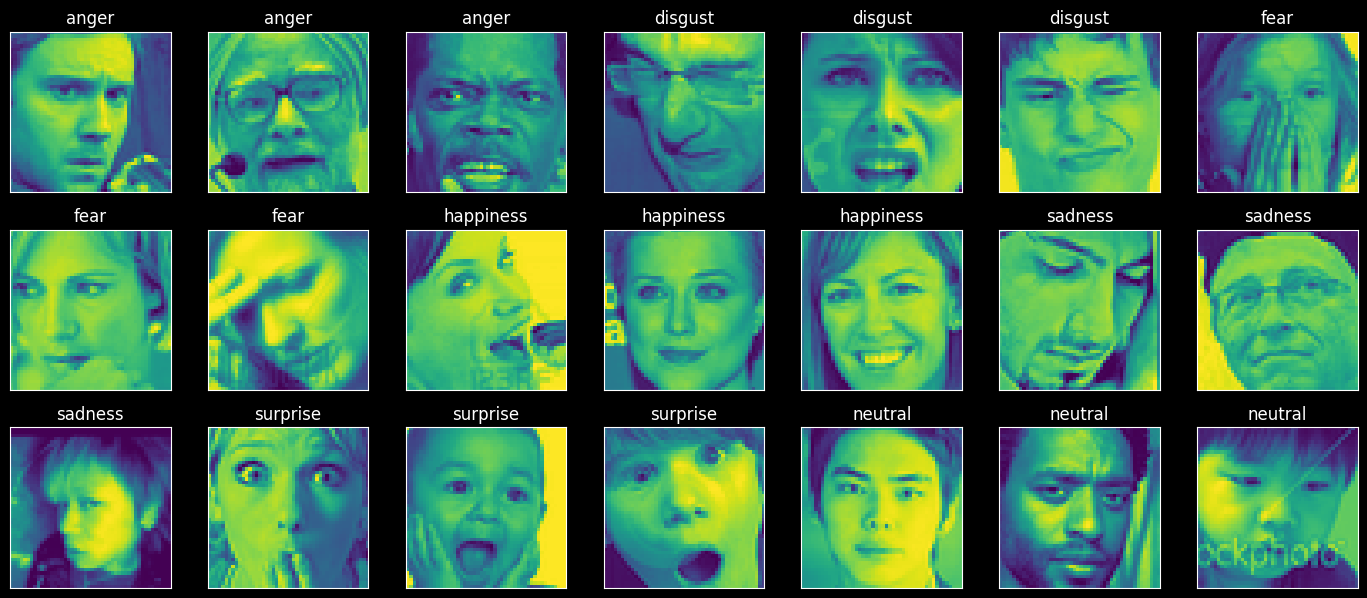

In [7]:
# Display some sample data
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(" ")).reshape(48, 48).astype("float32")
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [8]:
# Apply conversion function to all rows of data
img_array = df.pixels.apply(lambda x : np.array(x.split(" ")).reshape(48, 48, 1).astype("float32"))

In [9]:
# Arrange array
img_array = np.stack(img_array, axis = 0)
img_array.shape

(35887, 48, 48, 1)

In [10]:
# Obtain array of emotion labels
labels = df.emotion.values
labels

array([0, 0, 2, ..., 0, 3, 2])

In [11]:
# Split dataset into training and testing data
x_train, x_test, y_train, y_test = train_test_split(img_array, labels, test_size = 0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((28709, 48, 48, 1), (28709,), (7178, 48, 48, 1), (7178,))

In [14]:
# Normalise data (images)
x_train = x_train / 255
x_test = x_test / 255

In [31]:
# Create Sequential Model
base_model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(filters=32, 
                                                               kernel_size=(3, 3), 
                                                               activation='relu', 
                                                               input_shape=(48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),

                                        tf.keras.layers.Conv2D(filters=64, 
                                                               kernel_size=(3, 3), 
                                                               activation='relu', 
                                                               input_shape=(48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),

                                        tf.keras.layers.Conv2D(filters=128, 
                                                               kernel_size=(3, 3), 
                                                               activation='relu', 
                                                               input_shape=(48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),

                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(units=128, 
                                                              activation='relu'),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(units=7, 
                                                              activation='softmax') # 7 emotion classes

])
base_model.summary()

/Users/dylan/Documents/GitHub.nosync/facial-recognition/tf_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 23, 23, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,743 (1.36 MB)

 Trainable params: 356,295 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [32]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy', # Sparse as labels are integers (one-hot encoding)
                   metrics=['accuracy'])

In [15]:
# Make directory for storing model checkpoints
try:
    os.mkdir('checkpoints')
except:
    pass

In [33]:
file_name = 'best_model.keras'
checkpoint_path = os.path.join('checkpoints', file_name) 

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_freq='epoch',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='max')

In [34]:
# Start model training

base_model.fit(x=x_train, 
               y=y_train,
               epochs=20,
               validation_split=0.2,
               callbacks=call_back)

Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3109 - loss: 1.9244
Epoch 1: val_accuracy improved from -inf to 0.40247, saving model to checkpoints/best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.3110 - loss: 1.9241 - val_accuracy: 0.4025 - val_loss: 1.5413
Epoch 2/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4478 - loss: 1.4378
Epoch 2: val_accuracy did not improve from 0.40247
718/718 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4478 - loss: 1.4377 - val_accuracy: 0.3497 - val_loss: 1.9220
Epoch 3/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4992 - loss: 1.3151
Epoch 3: val_accuracy improved from 0.40247 to 0.45037, saving model to checkpoints/best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.4992 - loss: 1.3151 - val_accuracy: 0.4504 - val_loss: 1.4202
Epoch 4/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5278 - loss: 1.2361
Epoch 4: val_accuracy improved from 0.45037 t

actual label is neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted label is happiness


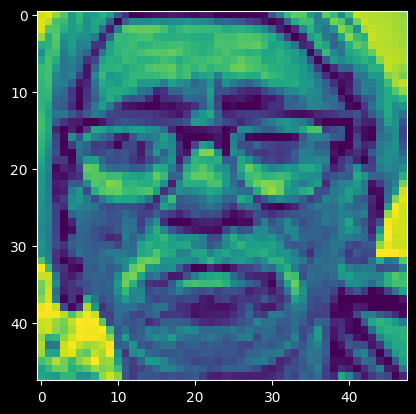

In [19]:
# Check model performance against test data

best_model = tf.keras.models.load_model(checkpoint_path)

for k in range(10):
    print(f'actual label is {label_to_text[y_test[k]]}')
    predicted_class = best_model.predict(tf.expand_dims(x_test[k], axis=0)).argmax()
    print(f'predicted label is {label_to_text[predicted_class]}')
    pyplot.imshow(x_test[k].reshape(48, 48))
    pyplot.show()
    time.sleep(1)
    clear_output(wait=True)

## Real-time prediction via webcam

In [19]:
# Set up face classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

# Set up labels
label_to_text = {0: "anger",
                    1: "disgust",
                    2: "fear",
                    3: "happiness",
                    4: "sadness",
                    5: "surprise",
                    6: "neutral"}

# Obtain best model
file_name = 'best_model.keras'
checkpoint_path = os.path.join('checkpoints', file_name) 
best_model = tf.keras.models.load_model(checkpoint_path)

# Access webcam
video_capture = cv2.VideoCapture(0)

In [20]:
# Function to classify emotions in video stream
def detect_classify_emotion(vid):
    # convert to grayscale for processing
    img_gray = cv2.cvtColor(vid, cv2.COLOR_BGR2GRAY)

    # detect faces available in video stream
    faces = face_classifier.detectMultiScale(img_gray, 1.1, 5, minSize = (40, 40))

    # process each available face in video stream
    for (x, y, w, h) in faces:
        # draw bounding box around face
        cv2.rectangle(vid, (x, y), (x + w, y + h), (0, 255, 0), 4)

        # pre-process face for model prediction
        face = img_gray[y:y + h, x:x + w]
        cropped_face = np.expand_dims(np.expand_dims(cv2.resize(face, (48, 48)), -1), 0)

        # preduct emotion using best model
        predicted_emotion = best_model.predict(cropped_face)
        max_index = int(np.argmax(predicted_emotion))
        cv2.putText(vid, label_to_text[max_index], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return faces


In [21]:

# Use a loop for real-time face detection
while True:

    result, video_frame = video_capture.read() # read frames from video
    if result is False:
        break # terminate the loop if the frame is not read successfully

    faces = detect_classify_emotion(video_frame)

    cv2.imshow("Dylan's Emotion Classifier Project", video_frame) # display processed frame in window

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

video_capture.release()
cv2.destroyAllWindows()

: 